### Libraries

In [116]:
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt
import re
from math import log
import csv
import matplotlib.dates as mdates
import seaborn as sns

# Metric: Transaction Response Times (TRT) in ms

## Formatting & Cleaning

### Freestyle format & testing

In [ ]:
# Filter the log file to remove unnecessary lines
transaction_pattern = re.compile(
    r"\|(\w+)\|MIN-(\d+(?:\.\d+)?)\|P50%-(\d+(?:\.\d+)?)\|P95%-(\d+(?:\.\d+)?)\|P99%-(\d+(?:\.\d+)?)\|MAX-(\d+(?:\.\d+)?)\|SAMPLES-(\d+)"
)
percentile_pattern = re.compile(r"PERCENTILES (\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})")

corrected_log = []

log_file_path = "data/filtered_transaction_data.log"

with open(log_file_path, "r") as file:
    for line in file:

        line = line.replace("Vuser 2:", "").strip()

        if "PERCENTILES" in line:
            timestamp_match = percentile_pattern.search(line)
            if timestamp_match:
                corrected_log.append(timestamp_match.group(1))
                continue

        if line.startswith("|gettimestamp") or "PostgreSQL tpm" in line:
            continue

        if transaction_pattern.search(line):
            corrected_log.append(line)

print("\n".join(corrected_log))

In [55]:
# P50% values for all transaction types over time
log_data = []
current_timestamp = ""
for line in corrected_log:
    if not line.startswith("|"):
        current_timestamp = line
    else:
        parts = line.strip("|").split("|")
        transaction_type = parts[0]
        p50_value = float(parts[2].split("-")[1])
        log_data.append([current_timestamp, transaction_type, p50_value])

In [38]:
# Create a DataFrame from the log data (P50 values of transactions over time)
df = pd.DataFrame(log_data, columns=["Timestamp", "Transaction", "P50"])
df_pivot = df.pivot(index="Timestamp", columns="Transaction", values="P50")
colors = ["blue", "green", "red", "purple", "orange"]
# Plotting
df_pivot.plot(kind="line", figsize=(10, 6), color=colors)
plt.xlabel("Timestamp")
plt.ylabel("P50 Value")
plt.title("P50 Values of Transactions Over Time")
plt.grid(True)
plt.legend(title="Transaction Type")
plt.show()

### Formatting according to HammerDB Documentation

In [59]:
filename = "data/filtered_transaction_data.log"

# Cell 2: Define the processing function
import re


def process_file_data(filename):
    xaxis = ""
    storedprocs_data = {
        proc: {"min": "", "p50": "", "p95": "", "p99": "", "max": ""}
        for proc in ["neword", "payment", "delivery", "slev", "ostat"]
    }

    with open(filename, "r") as file:
        file_data = file.readlines()

    for line in file_data:
        if "PERCENTILES" in line:
            timeval = line.split()[3]
            xaxis += f"{timeval}\t"

    print("TIME INTERVALS")
    print(f"\t{xaxis}")

    for storedproc in storedprocs_data:
        print(storedproc.upper())
        for line in file_data:
            if f"|{storedproc}|" in line:
                storedprocs_data[storedproc][
                    "min"
                ] += f"{re.search(r'MIN-([0-9.]+)', line).group(1)}\t"
                storedprocs_data[storedproc][
                    "p50"
                ] += f"{re.search(r'P50%-([0-9.]+)', line).group(1)}\t"
                storedprocs_data[storedproc][
                    "p95"
                ] += f"{re.search(r'P95%-([0-9.]+)', line).group(1)}\t"
                storedprocs_data[storedproc][
                    "p99"
                ] += f"{re.search(r'P99%-([0-9.]+)', line).group(1)}\t"
                storedprocs_data[storedproc][
                    "max"
                ] += f"{re.search(r'MAX-([0-9.]+)', line).group(1)}\t"

        print("MIN\t", storedprocs_data[storedproc]["min"])
        print("P50\t", storedprocs_data[storedproc]["p50"])
        print("P95\t", storedprocs_data[storedproc]["p95"])
        print("P99\t", storedprocs_data[storedproc]["p99"])
        print("MAX\t", storedprocs_data[storedproc]["max"])


process_file_data(filename)

TIME INTERVALS
	16:05:16	16:05:18	16:05:20	16:05:22	16:05:24	16:05:26	16:05:28	16:05:30	16:05:32	16:05:34	16:05:36	16:05:38	16:05:40	16:05:42	16:05:44	16:05:46	16:05:48	16:05:50	16:05:52	16:05:54	16:05:56	16:05:58	16:06:00	16:06:02	16:06:04	16:06:06	16:06:08	16:06:10	16:06:12	16:06:14	16:06:16	16:06:18	16:06:20	16:06:22	16:06:24	16:06:26	16:06:28	16:06:30	16:06:32	16:06:34	16:06:36	16:06:38	16:06:40	16:06:42	16:06:44	16:06:46	16:06:48	16:06:50	16:06:52	16:06:54	16:06:56	16:06:58	16:07:00	16:07:02	16:07:04	16:07:06	16:07:08	16:07:10	16:07:12	16:07:14	16:07:16	16:07:18	16:07:20	16:07:22	16:07:24	16:07:26	16:07:28	16:07:30	16:07:32	16:07:34	16:07:36	16:07:38	16:07:40	16:07:42	16:07:44	16:07:46	16:07:48	16:07:50	16:07:52	16:07:54	16:07:56	16:07:58	16:08:00	16:08:02	16:08:04	16:08:06	16:08:08	16:08:10	16:08:12	16:08:14	16:08:16	16:08:18	16:08:20	16:08:22	16:08:24	16:08:26	16:08:28	16:08:30	16:08:32	16:08:34	16:08:36	16:08:38	16:08:40	16:08:42	16:08:44	16:08:46	16:08:48	16:08:50	16:08:52	16:

### Formatting into csv

In [60]:
def process_file_data_to_csv(filename):

    timestamps = []
    data_rows = []

    storedprocs = ["neword", "payment", "delivery", "slev", "ostat"]

    with open(filename, "r") as file:
        for line in file:
            # Extract time intervals
            if "PERCENTILES" in line:
                timestamp = line.split()[3]
                if timestamp not in timestamps:
                    timestamps.append(timestamp)

            for storedproc in storedprocs:
                if f"|{storedproc}|" in line.lower():
                    min_val = re.search(r"MIN-([0-9.]+)", line).group(1)
                    p50_val = re.search(r"P50%-([0-9.]+)", line).group(1)
                    p95_val = re.search(r"P95%-([0-9.]+)", line).group(1)
                    p99_val = re.search(r"P99%-([0-9.]+)", line).group(1)
                    max_val = re.search(r"MAX-([0-9.]+)", line).group(1)

                    data_rows.append(
                        {
                            "Timestamp": timestamp,
                            "Transaction_Type": storedproc.upper(),
                            "MIN": min_val,
                            "P50%": p50_val,
                            "P95%": p95_val,
                            "P99%": p99_val,
                            "MAX": max_val,
                        }
                    )

    df = pd.DataFrame(data_rows)

    output_filename = filename.replace(".log", ".csv")
    df.to_csv(output_filename, index=False)

    print(f"Processed data has been saved to {output_filename}")


# Sample filename usage
filename = "data/filtered_transaction_data.log"
process_file_data_to_csv(filename)

Processed data has been saved to data/filtered_transaction_data.csv


## Read data tables into different frames

### Frame to capture Time Series for each transactiont type (neword, payment, delivery, slev, ostat)

In [63]:
filename = "data/filtered_transaction_data.csv"
df = pd.read_csv(filename)

transaction_types = ["NEWORD", "PAYMENT", "DELIVERY", "SLEV", "OSTAT"]

transaction_dfs = {}

# Create a DataFrame for each transaction type
for transaction in transaction_types:
    transaction_dfs[transaction] = df[df["Transaction_Type"] == transaction].copy()
    transaction_dfs[transaction].reset_index(drop=True, inplace=True)

### Frame to consolidate MIN, P50 and MAX for every transaction  

In [ ]:
# Create a new DataFrame to hold combined data for all transaction types and selected percentiles
combined_df = pd.DataFrame()

# For each transaction type, select only the Timestamp, MIN, P50%, and MAX columns
for transaction in transaction_types:
    temp_df = transaction_dfs[transaction][["Timestamp", "MIN", "P50%", "MAX"]]
    temp_df["Transaction_Type"] = (
        transaction  # Add a column to identify the transaction type
    )
    combined_df = combined_df.append(temp_df)

# Reset the index of the combined DataFrame
combined_df.reset_index(drop=True, inplace=True)

# Ensure 'Timestamp' is of datetime type
combined_df["Timestamp"] = pd.to_datetime(combined_df["Timestamp"])

# Here combined_df is ready for plotting

### Random plotting 

#### All percentiles for a single transaction type

In [ ]:
# Test Plot to show percentile values for a SINGLE transaction type
neword_df = transaction_dfs["NEWORD"]

# Converting timestamp strings to datetime objects for better plotting
neword_df["Timestamp"] = pd.to_datetime(neword_df["Timestamp"], format="%H:%M:%S")

# Plotting each percentile
plt.figure(figsize=(10, 6))
#plt.plot(neword_df["Timestamp"], neword_df["MIN"], marker="o", label="MIN")
plt.plot(neword_df["Timestamp"], neword_df["P50%"],label="P50%")
#plt.plot(neword_df["Timestamp"], neword_df["P95%"], marker="o", label="P95%")
#plt.plot(neword_df["Timestamp"], neword_df["P99%"], marker="o", label="P99%")
plt.plot(neword_df["Timestamp"], neword_df["MAX"], label="MAX")

plt.title("NEWORD Transaction Percentiles Over Time")
plt.xlabel("Time")
plt.ylabel("Latency")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()  
plt.show()

#### Neword vs P50 percentile limited

In [ ]:
neword_df["Timestamp"] = pd.to_datetime(neword_df["Timestamp"])

plt.figure(figsize=(20, 10))

plt.plot(
    neword_df["Timestamp"], neword_df["P50%"], label="P50%", linestyle="-"
)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xticks(rotation=45)

plt.xlabel("Time")
plt.ylabel("P50% Latency")
plt.title("NEWORD Transaction P50% Latency Over Time")

plt.grid(True)

lower_limit = 0
upper_limit = 500000

plt.ylim([lower_limit, upper_limit])

plt.tight_layout()

plt.legend()

plt.show()

#### Smoothed plot of neword vs. P50

In [ ]:
neword_df = pd.read_csv("data/filtered_transaction_data.csv")
neword_df["Timestamp"] = pd.to_datetime(neword_df["Timestamp"])

# Remove outliers that are beyond a certain percentile, e.g., 99th percentile
p99_threshold = neword_df["P50%"].quantile(0.95)
filtered_neword_df = neword_df[neword_df["P50%"] < p99_threshold]

# Apply a rolling window to smooth the data
rolling_window_size = 4 
filtered_neword_df["P50%_smooth"] = (
    filtered_neword_df["P50%"].rolling(rolling_window_size, center=True).mean()
)

plt.figure(figsize=(20, 6))

plt.plot(
    filtered_neword_df["Timestamp"],
    filtered_neword_df["P50%_smooth"],
    label="Smoothed P50%",
    #marker="o",
    linestyle="-",
)

# display the timestamp in a readable format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xticks(rotation=45)

# abels and title
plt.xlabel("Time")
plt.ylabel("P50% Latency (Smoothed)")
plt.title("NEWORD Transaction Smoothed P50% Latency Over Time")

plt.grid(True)

plt.legend()

# ensure overlapping doesnt happen
plt.tight_layout()

plt.show()

#### Plots for neword for each percentile values

In [ ]:
# Plots for each percentile for transaction type NEWORD on log scale
neword_df = transaction_dfs["NEWORD"]
neword_df["Timestamp"] = pd.to_datetime(neword_df["Timestamp"], format="%H:%M:%S")

# Create subplots for each percentile.
fig, ax = plt.subplots(5, 1, figsize=(10, 20), sharex=True)

percentiles = ["MIN", "P50%", "P95%", "P99%", "MAX"]
for i, percentile in enumerate(percentiles):
    ax[i].plot(
        neword_df["Timestamp"], neword_df[percentile], label=percentile
    )
    ax[i].set_ylabel("Latency")
    ax[i].set_title(f"{percentile} Over Time")
    ax[i].legend()
    ax[i].grid(True)
    ax[i].set_yscale("log") 

plt.xlabel("Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Preprocessing for CPD

### Multivariate CPD on P50-values of all transaction types

In [120]:
# reformatting the csv table
filename = "data/filtered_transaction_data.csv"
df = pd.read_csv(filename)
pivoted_df = df.pivot(index="Timestamp", columns="Transaction_Type", values="P50%")
pivoted_df.index = pd.to_datetime(pivoted_df.index)
data_matrix = pivoted_df.to_numpy()

/var/folders/dc/j23pwbpn4wv53vs6kgf55dkm0000gn/T/ipykernel_58137/1124635691.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pivoted_df.index = pd.to_datetime(pivoted_df.index)


### CPD Model fitting and detection

### Pelt algo with rbf-kernel for all transaction types and P50 Values (robust to outliers and representing mean data behavior)

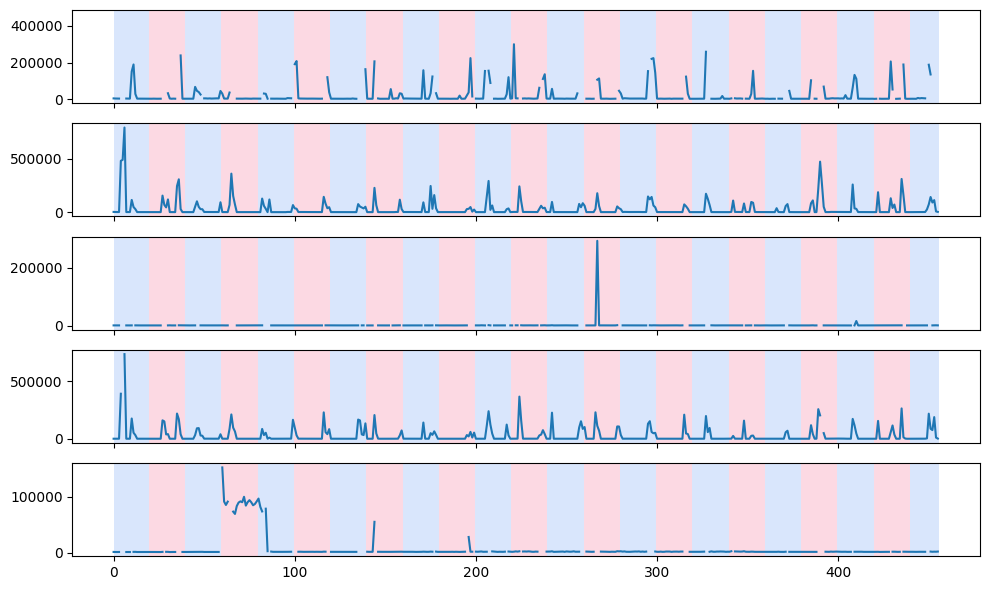

In [128]:
# modelling for multivariate analysis
model = "rbf"

algo = rpt.Pelt(model=model, min_size=1, jump=20).fit(data_matrix)

penalty_value = 10 * np.log(len(data_matrix))

change_points = algo.predict(pen=penalty_value)

rpt.display(data_matrix, change_points, figsize=(10, 6))

plt.show()

/var/folders/dc/j23pwbpn4wv53vs6kgf55dkm0000gn/T/ipykernel_58137/1968943574.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Timestamp"] = pd.to_datetime(df["Timestamp"])


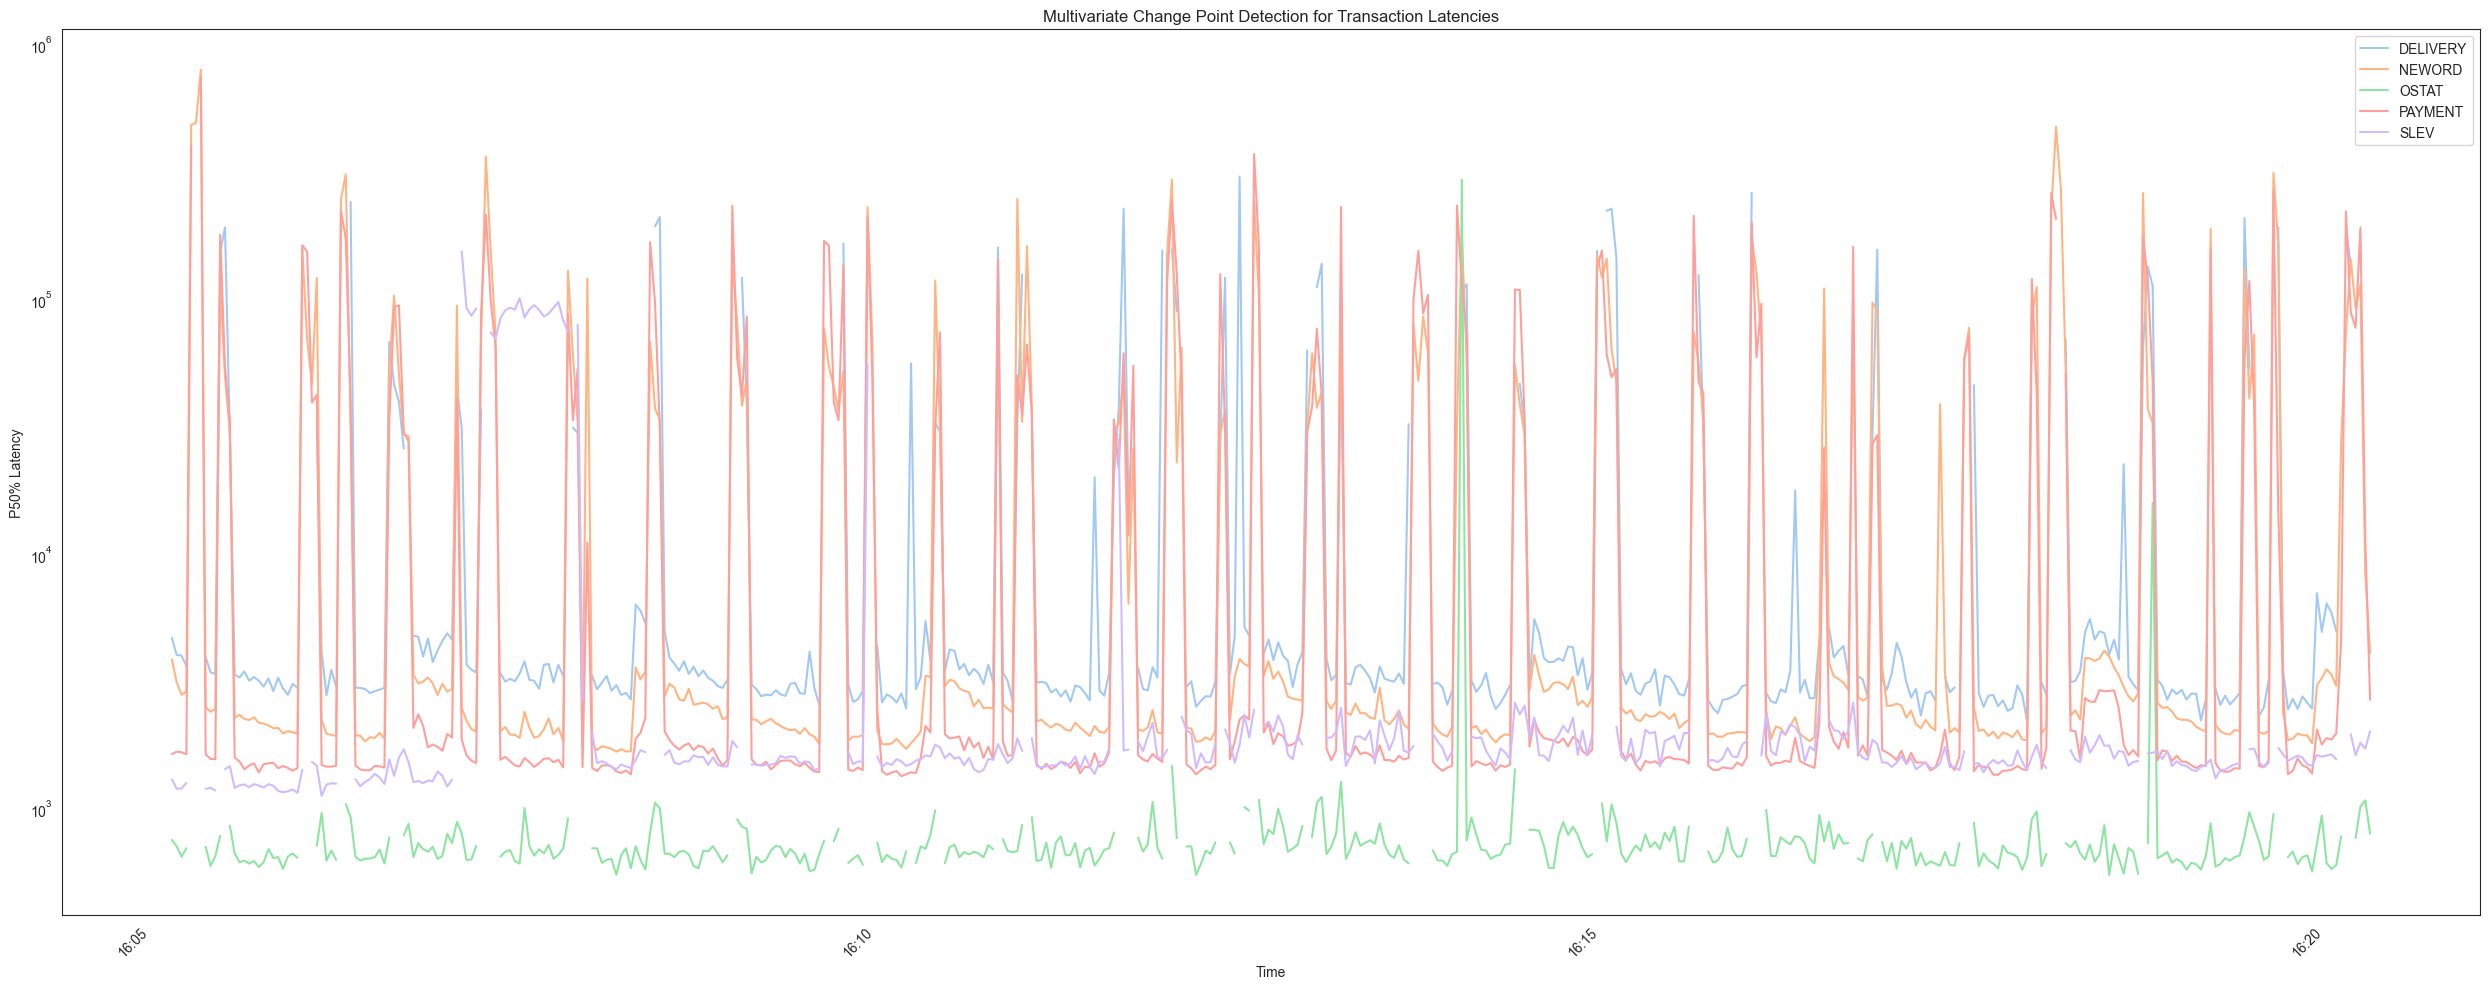

In [145]:
sns.set_style("white")

df = pd.read_csv("data/filtered_transaction_data.csv")
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

pivoted_df = df.pivot(index="Timestamp", columns="Transaction_Type", values="P50%")

# cpd
data_matrix = pivoted_df.values
model = "rbf"
algo = rpt.Pelt(model=model, min_size=1, jump=1).fit(data_matrix)
result = algo.predict(pen=10)

plt.figure(figsize=(25, 10))

plt.grid(False)

colors = sns.color_palette("pastel", len(pivoted_df.columns))

for i, column in enumerate(pivoted_df.columns):
    plt.plot(pivoted_df.index, pivoted_df[column], label=column, color=colors[i])

plt.xlabel("Time")
plt.ylabel("P50% Latency")
plt.title("Multivariate Change Point Detection for Transaction Latencies")
plt.legend()

# Formatting the x-axis
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.xticks(rotation=45)

plt.yscale("log")

plt.tight_layout()

plt.show()

### Kernel cpd using rbf-kernel for single transaction type

/var/folders/dc/j23pwbpn4wv53vs6kgf55dkm0000gn/T/ipykernel_58137/1050167019.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Timestamp"] = pd.to_datetime(df["Timestamp"])


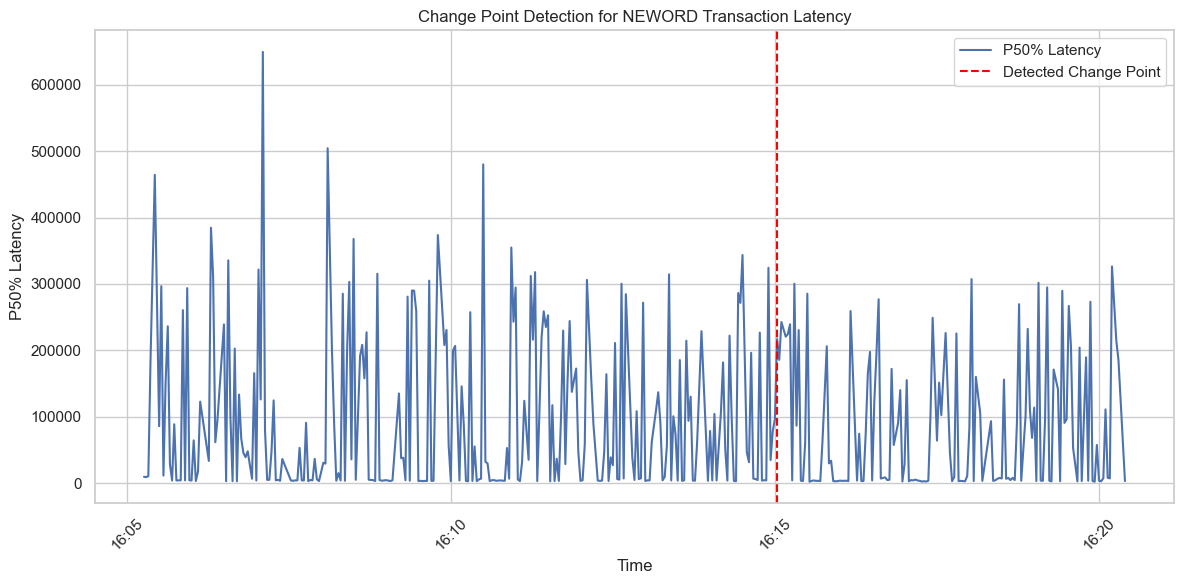

In [162]:
df = pd.read_csv("data/filtered_transaction_data.csv")
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

neword_df = df[df["Transaction_Type"] == "DELIVERY"]

data_matrix = neword_df["P99%"].values.reshape(-1, 1)  # Reshape for a single feature

model = "rbf"
algo = rpt.KernelCPD(kernel="rbf").fit(data_matrix)
result = algo.predict(n_bkps=2)  

plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

plt.plot(neword_df["Timestamp"], neword_df["P99%"], label="P50% Latency")

if result and 0 < result[0] < len(neword_df):
    plt.axvline(
        x=neword_df["Timestamp"].iloc[result[0]],
        color="red",
        linestyle="--",
        label="Detected Change Point",
    )

plt.xlabel("Time")
plt.ylabel("P50% Latency")
plt.title("Change Point Detection for NEWORD Transaction Latency")
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.xticks(rotation=45)

plt.tight_layout()

plt.show()

### DP approach for cpd on univaritate time series

/var/folders/dc/j23pwbpn4wv53vs6kgf55dkm0000gn/T/ipykernel_58137/2506853096.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Timestamp"] = pd.to_datetime(df["Timestamp"])


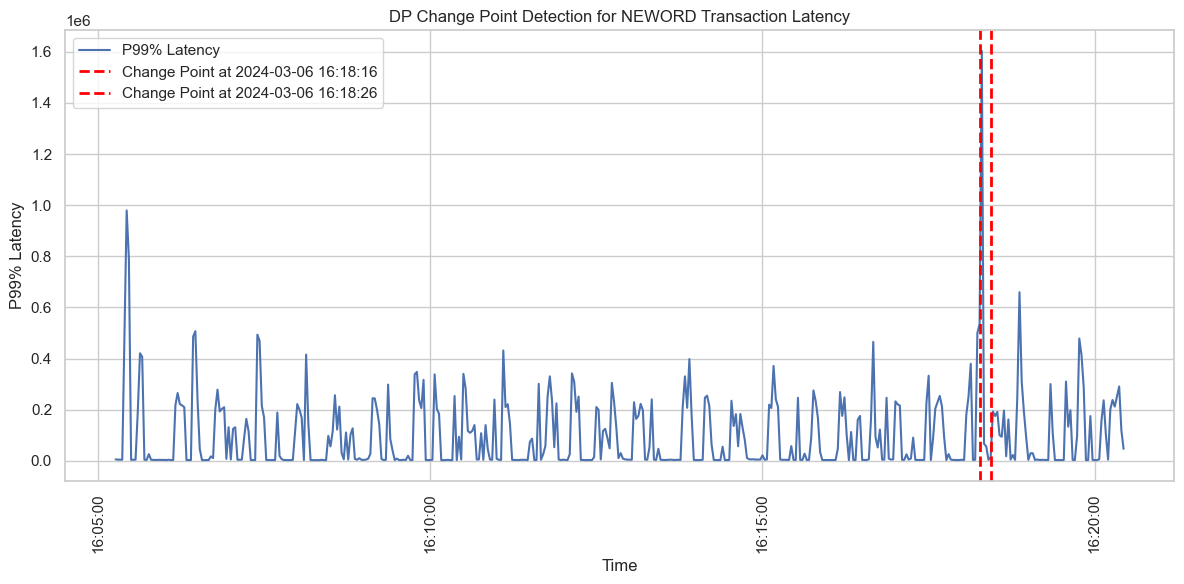

In [166]:
df = pd.read_csv("data/filtered_transaction_data.csv")
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

neword_df = df[df["Transaction_Type"] == "NEWORD"]

data_matrix = neword_df["P95%"].values.reshape(-1, 1)

# algorithm
model = "l2"  # euclidean distance 
algo = rpt.Dynp(model=model, min_size=1, jump=5).fit(data_matrix)
result = algo.predict(n_bkps=2)  

plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

plt.plot(neword_df["Timestamp"], neword_df["P95%"], label="P99% Latency")

for cp in result[:-1]:  
    plt.axvline(
        x=neword_df["Timestamp"].iloc[cp],
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Change Point at {neword_df['Timestamp'].iloc[cp]}",
    )

plt.xlabel("Time")
plt.ylabel("P99% Latency")
plt.title("DP Change Point Detection for NEWORD Transaction Latency")
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
plt.xticks(rotation=90)

plt.tight_layout()  

plt.show()